**This notebook contains the Pytorch implementation of GAN on  MNIST dataset . This the original MNIST dataset contains a lot of handwritten digits. I also applied GAN on Fashion-MNIST dataset due to redundancy i'm not going to upload that notebook.I will share result in Readme.md.**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision import datasets
import torch.optim as opt
from torch.autograd import Variable

In [0]:

def to_var(x):
    if torch.cuda.is_available():#utilize the gpu of the pc
        x = x.cuda()
    return Variable(x)

def denorm(x): #It used to restrict a value to a given range.
    out = (x + 1) / 2
    return out.clamp(0, 1)

**1. Simply downloading the FashionMNIST dataset with the help of Pytorch default setting provided in the dataset library , which is actually the second portion of the code.** 

**2. Then transforming the dataset into pytorch tensor data type so we can utilize the GPU.**

In [0]:
transform=transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((.5,),(.5,))
    
   
])

mnist=datasets.MNIST(
    root="./NewData/",
    download=True,
    train=True,
    transform=transform 
)

**Creating mini batches for training of size 64** 

In [0]:
dataloaders=torch.utils.data.DataLoader(mnist,shuffle=True,batch_size=64)

**h : size of hidden layer 1**<br>
**h2 : size of hidden layer 2**<br>
**Z  : input size of image or noise**
**It doesn't sounds very good size of layer 1 and layer 2 but it works the best after trying out a lot architecture.**

In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
h=128
h2=512
Z=100
lr=1e-3

dataiter=iter(dataloaders)
imgs,labels=dataiter.next()
print(imgs.size())
X=imgs.reshape(imgs.size(0),-1).size(1)
print(X)


torch.Size([64, 1, 28, 28])
784


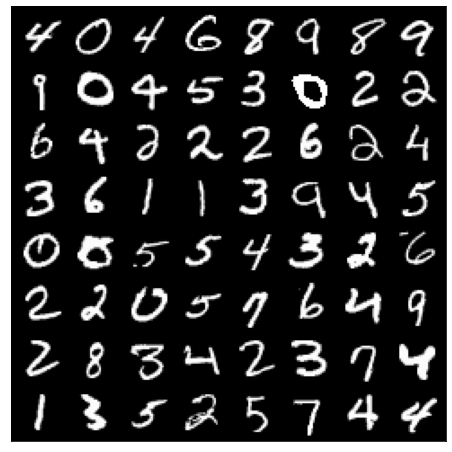

In [29]:
def imshow(imgs):
    imgs=torchvision.utils.make_grid(imgs)
    npimg=imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg,(1,2,0)),cmap="Greys_r")
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
imshow(imgs)

    

In [0]:
def Xav(m):
    if type(m)==nn.Linear:
         nn.init.xavier_uniform_(m.weight)
         m.bias.data.fill_(0)
    

**Building Generetor model** 

In [0]:
class gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
                              nn.Linear(Z,h),
                              nn.ReLU(),
                              nn.Linear(h,X),
                              nn.Sigmoid()
            

        )
        
        self.model.apply(Xav)
        
    def forward(self,input):
        return self.model(input)



In [0]:
 G=gen()

**Building Discriminator model** 

In [0]:
class dis(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
                                     nn.Linear(X,h),
                     nn.ReLU(),
                     nn.Linear(h,1),
                     nn.Sigmoid()
             
         )
        self.model.apply(Xav)
    
    def forward(self,input):
        return self.model(input)
  

In [34]:
D=dis()
print(D)

dis(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [0]:
if torch.cuda.is_available():
  D.cuda()
  G.cuda()

In [0]:
optimizer_D=opt.Adam(D.parameters(),lr=.0003)
optimizer_G=opt.Adam(G.parameters(),lr=.0003)
criterion = nn.BCELoss()

**Training the model**

Epoch=0,G_loss=7.4070525154121905,D_loss=0.03186927459312917


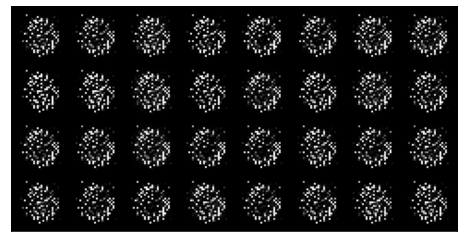

Epoch=10,G_loss=3.9752340382858633,D_loss=0.33362996057152494


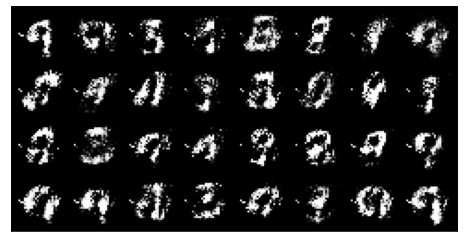

Epoch=20,G_loss=3.7231050958511416,D_loss=0.3969160071822372


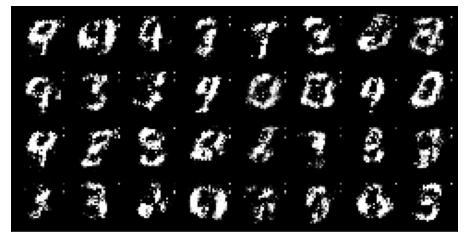

Epoch=30,G_loss=2.6143260957843966,D_loss=0.618191128918357


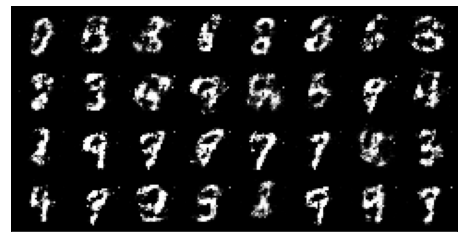

Epoch=40,G_loss=2.2530408039021848,D_loss=0.6844000965992271


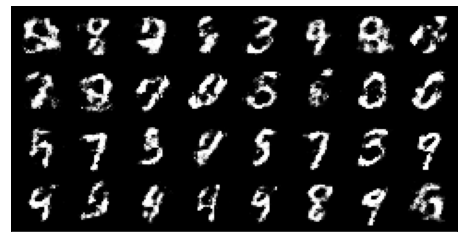

Epoch=50,G_loss=2.114781861620417,D_loss=0.7221935894379992


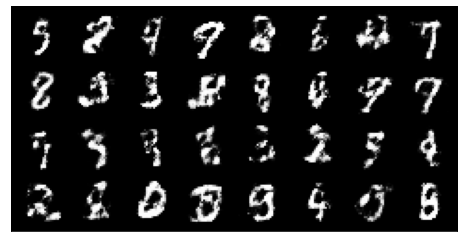

Epoch=60,G_loss=2.070973363258183,D_loss=0.7279862002777392


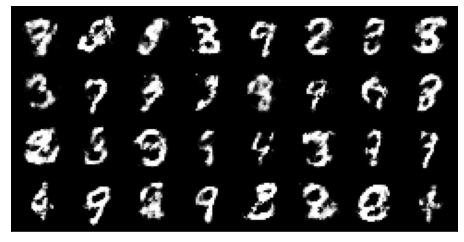

Epoch=70,G_loss=2.099755775572649,D_loss=0.7188843190987736


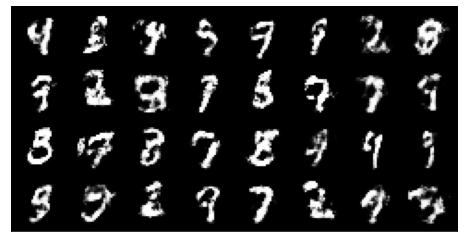

Epoch=80,G_loss=2.16982280610721,D_loss=0.6900890908007429


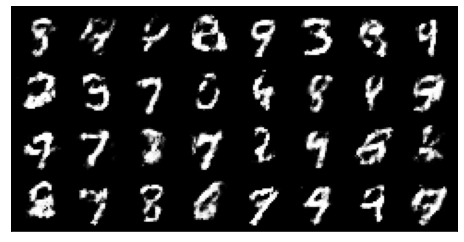

Epoch=90,G_loss=2.215656401760288,D_loss=0.6682431309271469


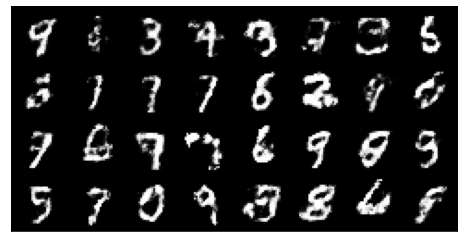

In [39]:
from torchvision.utils import save_image
c=0
for epoch in range(100):
    G_loss_run=0.
    D_loss_run=0.
    for i,(images,_) in enumerate(dataloaders):
              bs=images.size(0)
              images = to_var(images.view(images.size(0), -1))
              
              z=to_var(torch.randn(bs,Z))
              real_label=to_var(torch.ones(bs,1))
              fake_label=to_var(torch.zeros(bs,1))
              D_real=D(images)
              D_fake=D(G(z))

              D_real_loss=criterion(D_real,real_label)
              D_fake_loss=criterion(D_fake,fake_label)
              D_loss=D_real_loss+D_fake_loss
              optimizer_D.zero_grad()
              D.zero_grad()
              D_loss.backward()
              optimizer_D.step()

              z=to_var(torch.randn(bs,Z))
              D_fake=D(G(z))
              G_loss=criterion(D_fake,real_label)
              optimizer_G.zero_grad()
              D.zero_grad()
              G.zero_grad()
              G_loss.backward()
              optimizer_G.step()

              G_loss_run +=G_loss.item()
              D_loss_run +=D_loss.item()
    
    if epoch%10==0:
      print("Epoch={},G_loss={},D_loss={}".format(epoch,G_loss_run/(i+1),D_loss_run/(i+1)))

      sample=G(z).detach() 
      sample=sample.cpu()
      sample=sample.view(sample.size(0),1,28,28)
      imshow(sample)
      c=c+1
      #save_image(sample,"./gan/"+str(c)+".png")